In [78]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
all_data_df = pd.read_csv('./../../../Databases/clean_data.csv')

In [11]:
all_data_df.head()

,Id,SiteId,Timestamp,TotalEntries,TotalOuts,TotalAccesses,TotalEntriesMen,TotalEntriesWoman,Temperature,Precipitation
0,2305,2,2017-01-04 00:00:00,0,0,0,0.0,0.0,10.7,0.0
1,2306,2,2017-01-04 00:30:00,0,0,0,0.0,0.0,10.8,0.0
2,2307,2,2017-01-04 01:00:00,0,0,0,0.0,0.0,10.9,0.0
3,2308,2,2017-01-04 01:30:00,0,0,0,0.0,0.0,11.0,0.0
4,2309,2,2017-01-04 02:00:00,0,0,0,0.0,0.0,11.1,0.0


In [56]:
ravn_df = all_data_df[all_data_df['SiteId'] == 1][['Timestamp', 'TotalEntries', 'Temperature', 'Precipitation']]
ravn_df['Timestamp'] = pd.to_datetime(ravn_df['Timestamp'], dayfirst=True)
ravn_df.set_index('Timestamp', inplace=True)
ravn_df.sort_index(inplace=True)

In [57]:
ravn_df.head()

,TotalEntries,Temperature,Precipitation
Timestamp,,,
2018-11-27 00:00:00,0,10.2,0.0
2018-11-27 00:30:00,0,9.8,0.0
2018-11-27 01:00:00,0,10.0,0.0
2018-11-27 01:30:00,0,9.6,0.0
2018-11-27 02:00:00,0,9.8,0.0


In [16]:
# Checking the continuity of the time series:

test_ravn = ravn_df.asfreq('30T')
pd.Series(test_ravn[test_ravn['TotalEntries'].isnull()].index).describe()

count     0
unique    0
Name: Timestamp, dtype: int64

In [18]:
# Looking for null values:

ravn_df.isnull().sum()

TotalEntries     0
Temperature      0
Precipitation    0
dtype: int64

In [17]:
ravn_df.describe()

,TotalEntries,Temperature,Precipitation
count,4320.000000,4320.000000,4320.000000
mean,449.775694,11.970046,0.007292
std,462.897788,2.701045,0.116143
min,0.000000,3.400000,0.000000
25%,70.000000,10.100000,0.000000
50%,276.000000,12.000000,0.000000
75%,753.000000,13.700000,0.000000
max,2082.000000,23.100000,4.200000


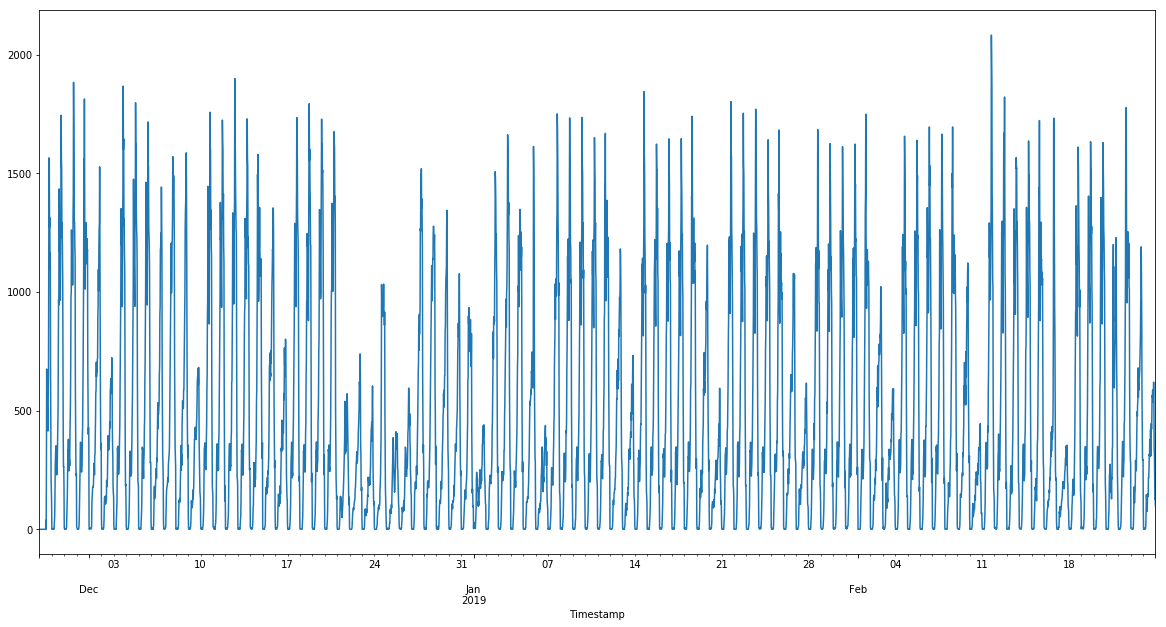

In [80]:
ravn_df['TotalEntries'].plot()
plt.show()

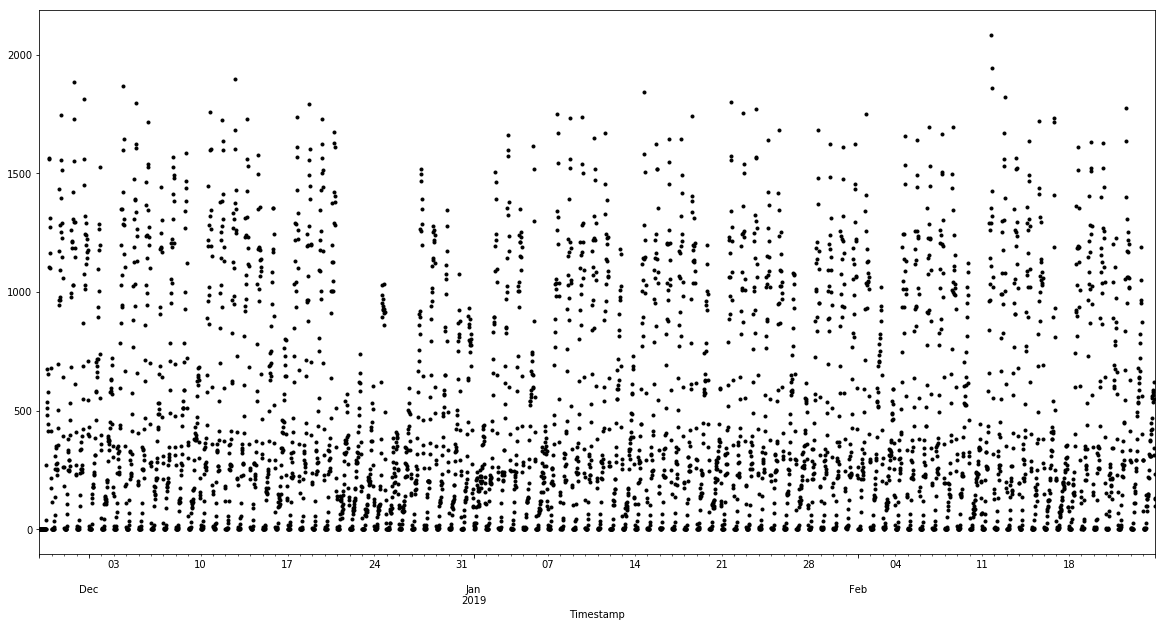

In [81]:
# Let's see the distribution/density of the observations as dots:

ravn_df['TotalEntries'].plot(style='k.')
plt.show()

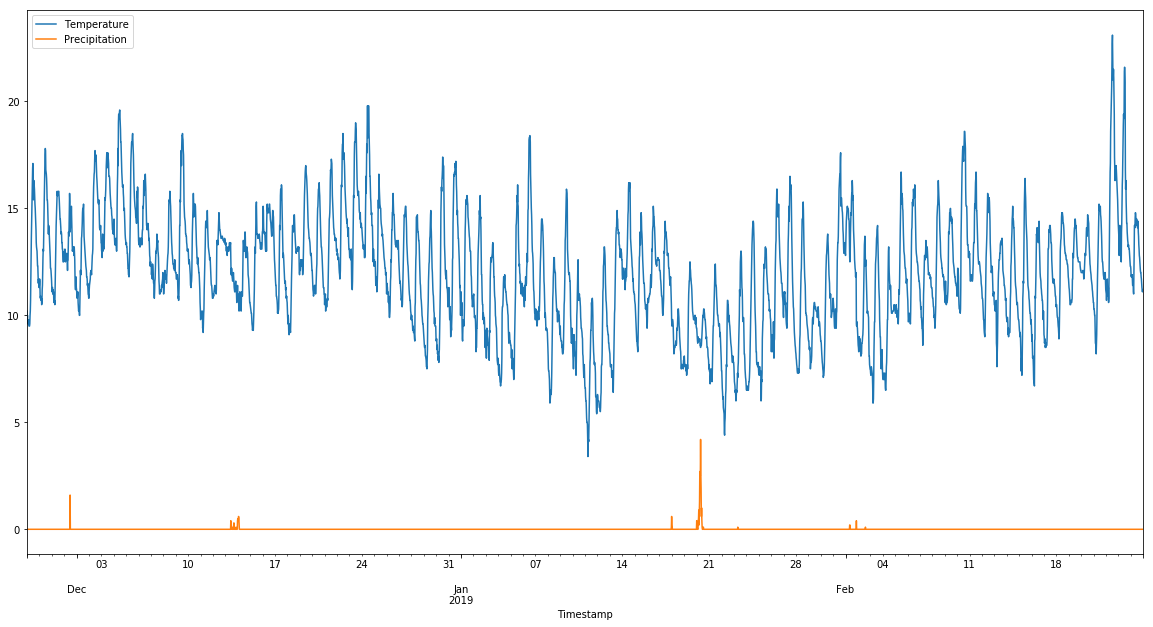

In [82]:
ravn_df[['Temperature', 'Precipitation']].plot()
plt.show()

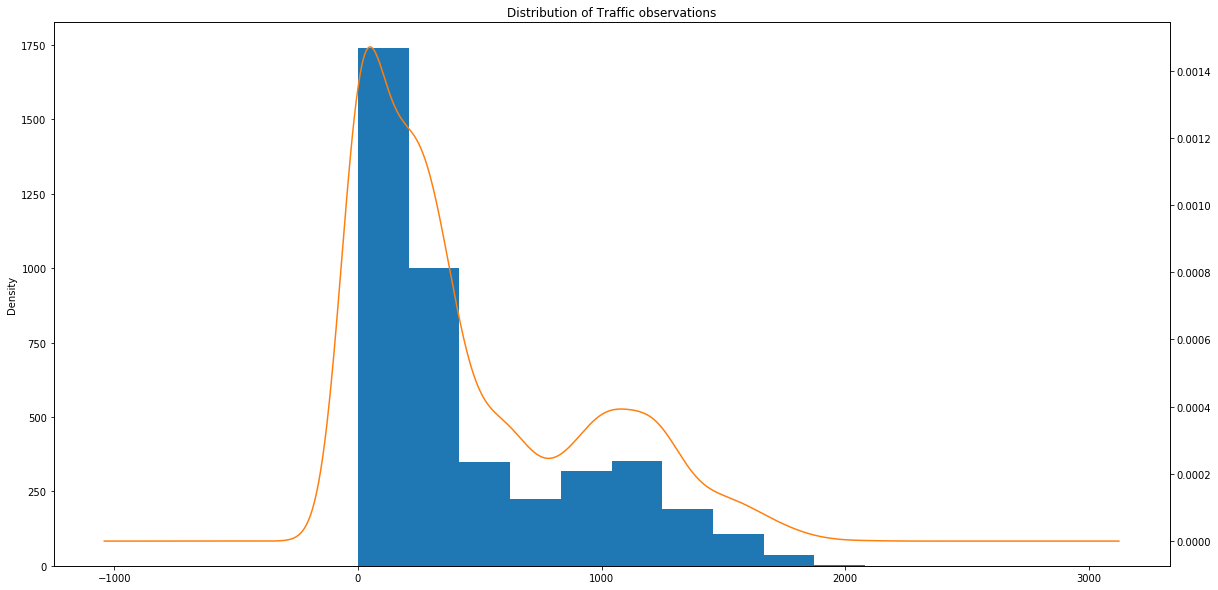

In [83]:
# Traffic observations distribution

ax = ravn_df['TotalEntries'].hist()
ravn_df.TotalEntries.plot(kind='kde', ax=ax, title='Distribution of Traffic observations', secondary_y=True)
plt.show()

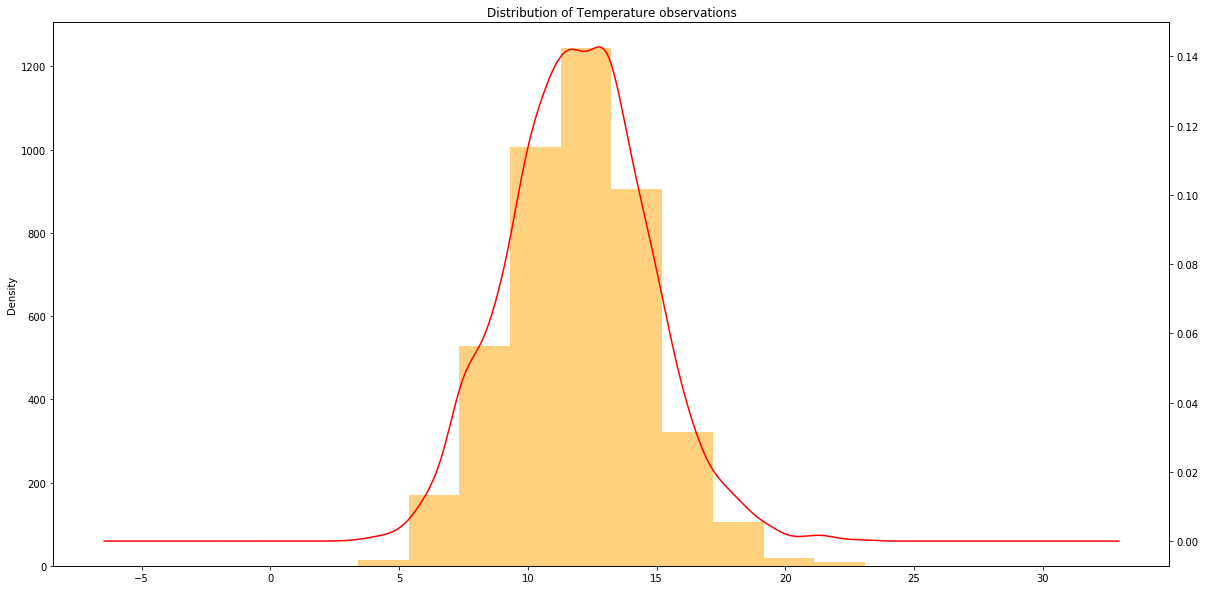

In [84]:
# Temperature observations distribution

ax = ravn_df['Temperature'].hist(alpha=0.5, color='orange')
ravn_df.Temperature.plot(kind='kde', color='red', ax=ax, title='Distribution of Temperature observations', secondary_y=True)
plt.show()

Since there was precipitiation in just a few timestamps, thre's no point in plotting the precipitation observations distribution (it would be mostly 0).

In [68]:
# Let's plot the TotalEntries data segregated by months to get an idea of its distribution:

ravn_groups = ravn_df['TotalEntries'].groupby(pd.Grouper(freq= 'M'))
ravn_months = pd.concat([pd.DataFrame(x[1].values) for x in ravn_groups], axis = 1)
ravn_months.columns = ['Nov', 'Dec', 'Jan', 'Feb']
ravn_months.head()

,Nov,Dec,Jan,Feb
0,0.0,15,3,1.0
1,0.0,0,27,0.0
2,0.0,5,19,0.0
3,0.0,2,15,0.0
4,0.0,5,8,0.0


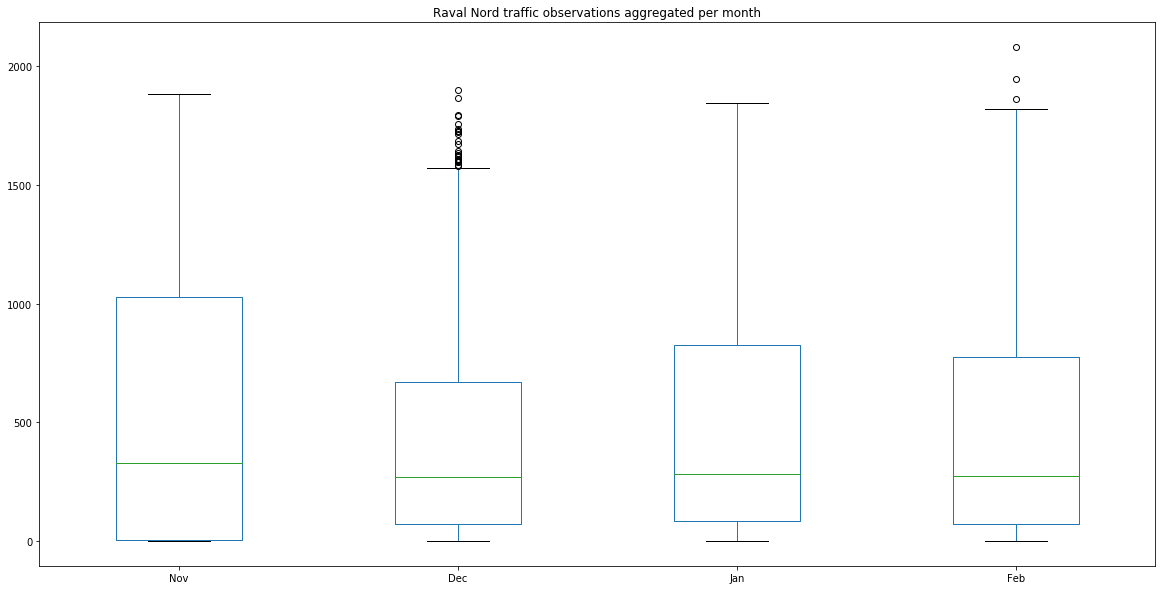

In [88]:
ravn_months.plot(kind='box', title='Raval Nord traffic observations aggregated per month')
plt.show()

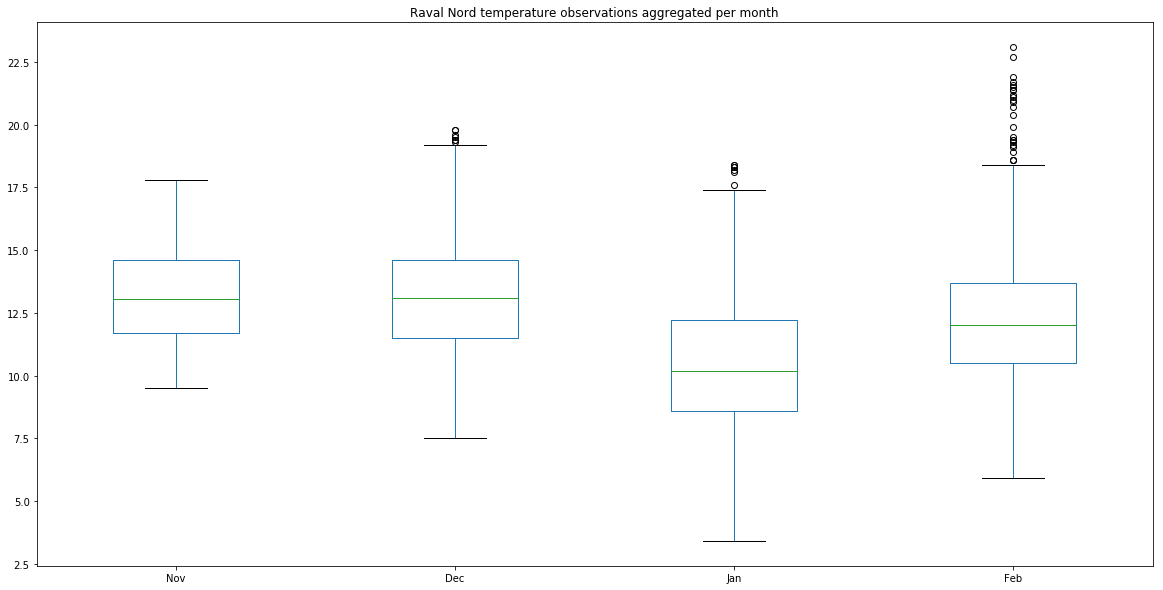

In [95]:
# Let's plot the TotalEntries data segregated by months to get an idea of its distribution:

ravn_temp_groups = ravn_df['Temperature'].groupby(pd.Grouper(freq= 'M'))
ravn_temp_months = pd.concat([pd.DataFrame(x[1].values) for x in ravn_temp_groups], axis = 1)
ravn_temp_months.columns = ['Nov', 'Dec', 'Jan', 'Feb']
ravn_temp_months.plot(kind='box', title='Raval Nord temperature observations aggregated per month')
plt.show()

Distribution of Traffic data along months


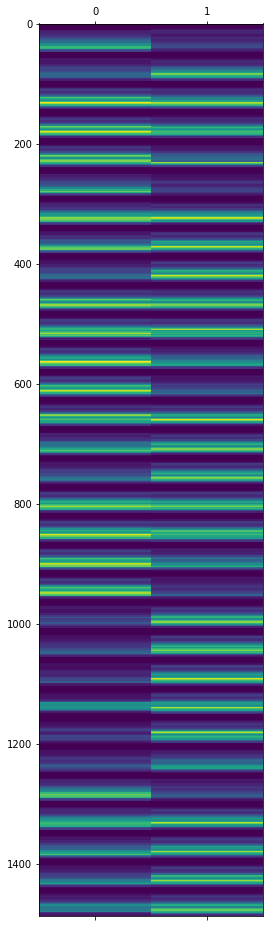

In [96]:
# Heatmap, to get an idea of the distribution of the traffic data along the months.

print('Distribution of Traffic data along months')
plt.matshow(ravn_months[['Dec', 'Jan']], interpolation=None, aspect='auto')
plt.show()

On the heatmap, each day can be observed as a 'cilinder', and a regular week can be observed as a series of 5 brigther cilinders followed by 2 darker ones. The granularity of the data allows for the perception of relief. 